In [2]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from scipy import sparse

from setup_networks import network_from_txt, network_indices, Network, triangular_lattice_pts, get_edges, network_from_edges_and_nodes
from currents import * 
from adaptation import adaptation_ode, ss_solve
from measures import steady_state_dissipation, area_penalty, cost
from phase_diagrams import get_sinks, remove_edges, make_ellipse_netw#, netw_to_nx

In [4]:
N_nodes = 10000
ellipse_ratio = 1.0
insertion_point_str = 'center'
edge_len = 0.8

replicate = 1

In [5]:
K = np.loadtxt(f'../data/expgrowth_el{ellipse_ratio}_ip{insertion_point_str}/Ks/K_kappa0.001_rho1.0_replicate{replicate}.txt')
sinks = np.loadtxt(f'../data/expgrowth_el{ellipse_ratio}_ip{insertion_point_str}/sink_nodes/sink_nodes_kappa0.001_rho1.0_replicate{replicate}.txt')
sinks = np.array(sinks, dtype=int)
len(sinks)

40

In [8]:
nodes = triangular_lattice_pts(N_nodes, 0.08)
edges = get_edges(nodes)
netw_ = network_from_edges_and_nodes(edges, nodes)
netw = make_ellipse_netw(netw_, 0.5, 0.5)
netw = make_ellipse_netw(netw, 1.0, ellipse_ratio)

In [16]:
def sqrt_area_of_network(netw, ellipse_ratio):
    inds = network_indices(netw)
    left_idx = inds['left']
    dist_fn = lambda x: np.linalg.norm(x[left_idx] - x, axis=1)
    dists = dist_fn(netw.pos)
    long_axis = np.max(dists) / 2
    short_axis = long_axis*ellipse_ratio
    return np.sqrt(np.pi * long_axis * short_axis)

sqrt_area_of_network(netw, ellipse_ratio)

4.685719020322105

(0.7655999999999998, 7.154399999999999, 0.20923173755432034, 6.580407428115679)

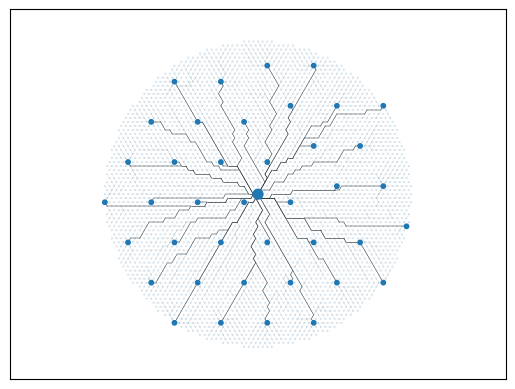

In [9]:
inds = network_indices(netw)
insertion_point = inds[insertion_point_str]

G = nx.Graph()
node_pos = netw.pos
node_dict = {}
for n in np.arange(len(node_pos)):
    node_dict[n] = node_pos[n]

edges = netw.edgelist
G.add_nodes_from(np.arange(len(node_pos)))
G.add_edges_from(edges)

sizes = np.ones(len(node_pos))*0.01
sizes[sinks] = 10.0
sizes[insertion_point]=50.0

nx.draw_networkx(G, pos=node_dict, width=K**0.25, with_labels=False, node_size=sizes);
plt.axis('equal')

In [241]:
def netw_to_nx(netw, K):
    G = nx.Graph()
    weighted_edges = np.append(netw.edgelist, 1/K[:, np.newaxis], 1)
    G.add_nodes_from(np.arange(len(netw.pos)))
    G.add_weighted_edges_from(weighted_edges, weight='K')
    return G

In [242]:
def distance_insertion_to_branch_points(netw, K, insertion_point='center'):
    clipped_netw, clipped_K = remove_edges(netw, K)
    G = netw_to_nx(clipped_netw, clipped_K)
    
    inds = network_indices(clipped_netw)
    source = inds[insertion_point]
    
    degrees = np.array(list(G.degree))
    branch_points = np.where(degrees[:, 1] > 2)[0]
    
    
    path_length = []
    path_weight = []
    for b in branch_points:
        path = nx.dijkstra_path(G, source, b, weight='K')
        pathweight = nx.path_weight(G, path, weight='K')
        
        path_length += [len(path)]
        path_weight += [pathweight]
        
    return path_length, path_weight
    
    

In [243]:
lengths, weights = distance_insertion_to_branch_points(netw, K)
np.sort(weights)

array([  0.        ,   2.82590443,   5.0616003 ,  10.52468938,
        10.7937346 ,  18.25664381,  18.28934331,  24.98757126,
        26.20630921,  29.61095159,  32.60664501,  37.53969107,
        58.42412047, 131.13384344, 152.10211659, 158.91486521,
       172.08171608, 174.59939604, 231.54926444, 237.29957152,
       237.37433852, 254.25585483, 285.49822089, 285.80596061,
       310.98565378, 334.2846309 , 335.07146662, 363.65168412,
       379.5897113 , 760.60761997])

(array([1., 2., 3., 3., 2., 3., 2., 0., 0., 3., 1., 2., 3., 1., 2., 0., 0.,
        1., 0., 1.]),
 array([ 1.  ,  1.95,  2.9 ,  3.85,  4.8 ,  5.75,  6.7 ,  7.65,  8.6 ,
         9.55, 10.5 , 11.45, 12.4 , 13.35, 14.3 , 15.25, 16.2 , 17.15,
        18.1 , 19.05, 20.  ]),
 <BarContainer object of 20 artists>)

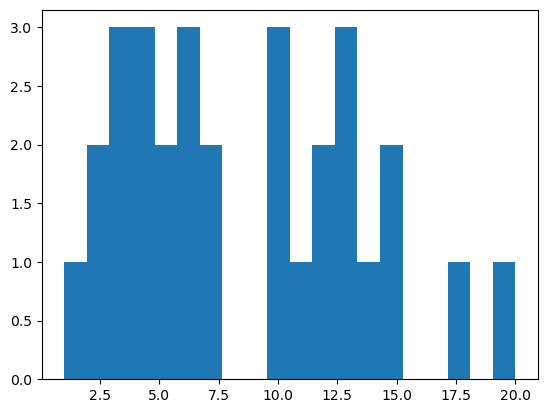

In [244]:
plt.hist(lengths, bins=20)

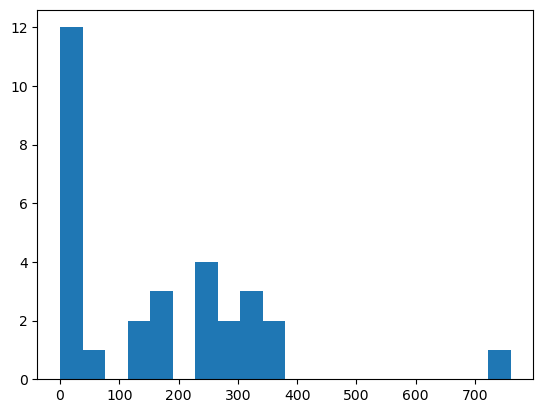

In [245]:
plt.hist(weights, bins=20);